### This is to make a map figure that shows the intrusions of mCDW in Antarctica and highlights our region of study in the context of East Antarctica.
#### It requires the XXXLarge core (the largest plus memory increment)

#### Here we will have: 
##### - Bottom temperature inside the 1000m isobath (could only make one year only because it is very heavy. I chose 2012 because it is the year where we have more obs)
##### - Obs version inside the 1000m isobath (code for that still not working)
##### - Add the box on the graphs, increase fonts. Export new ones and make new bt fig as it is marginally better than v1 because the intrusion in VB is more evident. 


### IMPORT PACKAGES

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
import matplotlib.colors as mcolors
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42393,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:33649,Total threads: 4
Dashboard: /proxy/34789/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:43419,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### LOAD DATA SETS

### 1. Load temperature from IAF at determined depth

In [4]:
# load temperature data at 400m:

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-63)
lon_slice  = slice(-275, -200)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

In [5]:
#average for temperature 
temp_400m_avg = temp_400m.mean('time')

In [6]:
# load temperature data at 400m:

depth_slice = 1000
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-50)
#lon_slice  = slice(-275, -200)

temp_1000m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_1000m = temp_1000m.sel(yt_ocean=lat_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_1000m = temp_1000m.load()

In [7]:
#average for temperature 
temp_1000m_avg = temp_1000m.mean('time')

In [8]:
## too heavy for memmory, couldn't do for the whole cycle. Maybe try choosing just the last 10 years of data.
first_year = '2012'
last_year = '2012'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

##load bottom temperature
lat_slice  = slice(-75.5,-62)
#lon_slice  = slice(-275, -200)

temp_bt= cc.querying.getvar(iaf_cycle3,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15

# select out bottom temperature values:
depth_array = temp_bt*0 + temp_bt.st_ocean
# find bottom grid cell at each lat/lon:
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
# select out bottom values:
bottom_temp_cycle3 = temp_bt.where(depth_array.st_ocean >= max_depth)
bottom_temp_cycle3 = bottom_temp_cycle3.sum(dim = 'st_ocean')


In [9]:
#load data
bottom_temp_cycle3 = bottom_temp_cycle3.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

In [10]:
#average for bottom temperature
bottom_temp_cycle3_avg = bottom_temp_cycle3.mean('time')

### LOAD SEAL DATA

In [47]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-275, -200)
lat_slice  = slice(-75.5,-62)

In [48]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [49]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

In [50]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

#### Select out profiles in correct region (East Antarctica)

In [18]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/jk72/ns3783/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>0).where(lon<180).where(lat<-62).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 26.5 s, sys: 27.2 s, total: 53.7 s
Wall time: 1min 48s


In [19]:
np.shape(WAP_FileList)

(334,)

In [61]:
# testing to figure out how many profiles we have to run in the next cell
np.size(profile_data.TEMP_ADJUSTED)

8056

In [60]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:
# actually I am not sure if this code selects the profiles on the shelf, I don't think it does. 

nprofiles = 705000 # tested with one run / so this is all good. I know this is the right number for this dataset (424 x 1000)
ndepth = 1000 #although I have downloaded the profiles with no interpolation, some might have been interpolated because it doesn't run with less than 1000 levels
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
sal = np.zeros((nprofiles,ndepth))

temp_0 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_0 = np.zeros((nprofiles,1))
temp_100 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_100 = np.zeros((nprofiles,1))
temp_300 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_300 = np.zeros((nprofiles,1))
temp_500 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_500 = np.zeros((nprofiles,1))

sal_0 = np.zeros((nprofiles,1)) 
sal_100 = np.zeros((nprofiles,1)) 
sal_300 = np.zeros((nprofiles,1)) 
sal_500 = np.zeros((nprofiles,1)) 

lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
#date_obs = np.zeros((nprofiles)) 
year_obs = np.zeros((nprofiles))
month_obs = np.zeros((nprofiles))

profile_count = 0

for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    juld = profile_data.JULD
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        temp_profile = profile_data.TEMP_ADJUSTED[profile]
        sal_profile = profile_data.PSAL_ADJUSTED[profile]
        if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
            # check the dive reached at least 200 dbar:
            pres_profile = profile_data.PRES_ADJUSTED[profile]
            if pres_profile.max() > 200:
                date = np.append(date,profile_data.JULD[profile])
                #date_obs[profile_count] = date[profile]
                year_obs[profile_count] = profile_data.JULD[profile].dt.year #this is an add on to lock months and years separately
                month_obs[profile_count] = profile_data.JULD[profile].dt.month
                # save profile:
                lat_obs[profile_count] = lat[profile]
                lon_obs[profile_count] = lon[profile]
                # find depth of profile:
                nlevels = len(profile_data.PRES_ADJUSTED[profile])
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                sal[profile_count,:nlevels] = sal_profile
               
                profile_count += 1

CPU times: user 14min, sys: 1min 4s, total: 15min 4s
Wall time: 13min 56s


In [54]:
np.size(temp)

424000000

## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [62]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(sal,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [63]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [64]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [65]:
np.unique(year_obs)

array([   0., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.])

In [66]:
nprofiles

705000

### Interpolating the seal data to the model grid. >> this is working know, but I am not sure what exactly I have done that got it right. Maybe you have to have the exact grid size


In [67]:
%%time
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles,50))

for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_profile = pres[profile,:][pres[profile,:]>0]
    temp_profile = temp_conservative[profile,:][pres[profile,:]>0]
    # also remove missing temperature points:
    temp_profile_adj = temp_profile[temp_profile!=0]
    pres_profile_adj = pres_profile[temp_profile!=0]
    
    f = interpolate.interp1d(pres_profile,temp_profile,bounds_error=False)
    temp_interp[profile,:] = f(st_ocean)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

### saving data

### 2. Calculate bottom temperature and load

### 3. Load seal data 

## Cut onshore mask 

In [11]:
# cut the data BOX 1
#lon_slice  = slice(-275,-200)
lat_slice  = slice(-75.5,-50)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

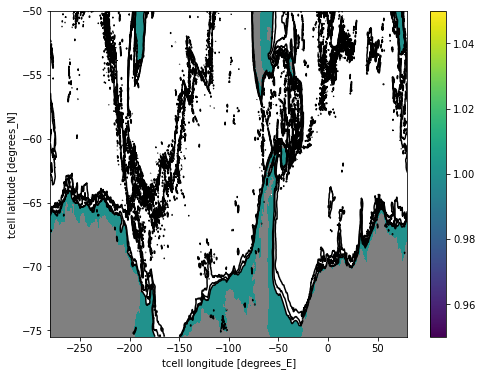

In [12]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/v45/ns3783/scripts/masks/Fig1_mask1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [13]:
#apply the mask
temp_400m_off = temp_400m_avg*region_mask
temp_400m_off = temp_400m_off.where(temp_400m_off!=0)

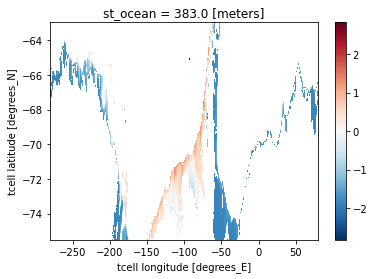

In [14]:
# first time step only:
temp_400m_off.plot()

In [15]:
## too heavy for model, couldn't load the data. 
#apply the mask to bottom temperature
bottom_temp_cycle3_off = bottom_temp_cycle3_avg*region_mask
bottom_temp_cycle3_off = bottom_temp_cycle3_off.where(temp_400m_off!=0)

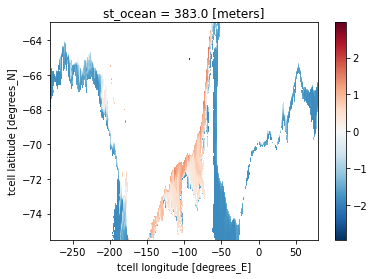

In [16]:
# first time step only:
bottom_temp_cycle3_off.plot()

## Cut offshore mask 

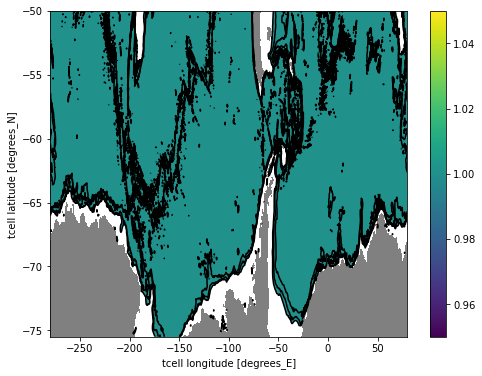

In [17]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/v45/ns3783/scripts/masks/Fig1_mask1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [18]:
#apply the mask
temp_1000m_off = temp_1000m_avg*region_mask
temp_1000m_off = temp_1000m_off.where(temp_1000m_off!=0)

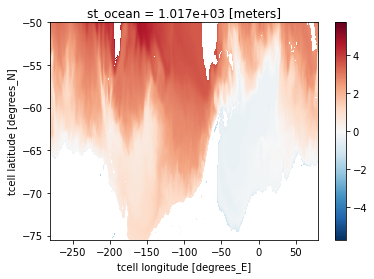

In [19]:
# first time step only:
temp_1000m_off.plot()

### PLOT MAP v1: IAF temp at 400m in the continental shelf and at 1000m offshore

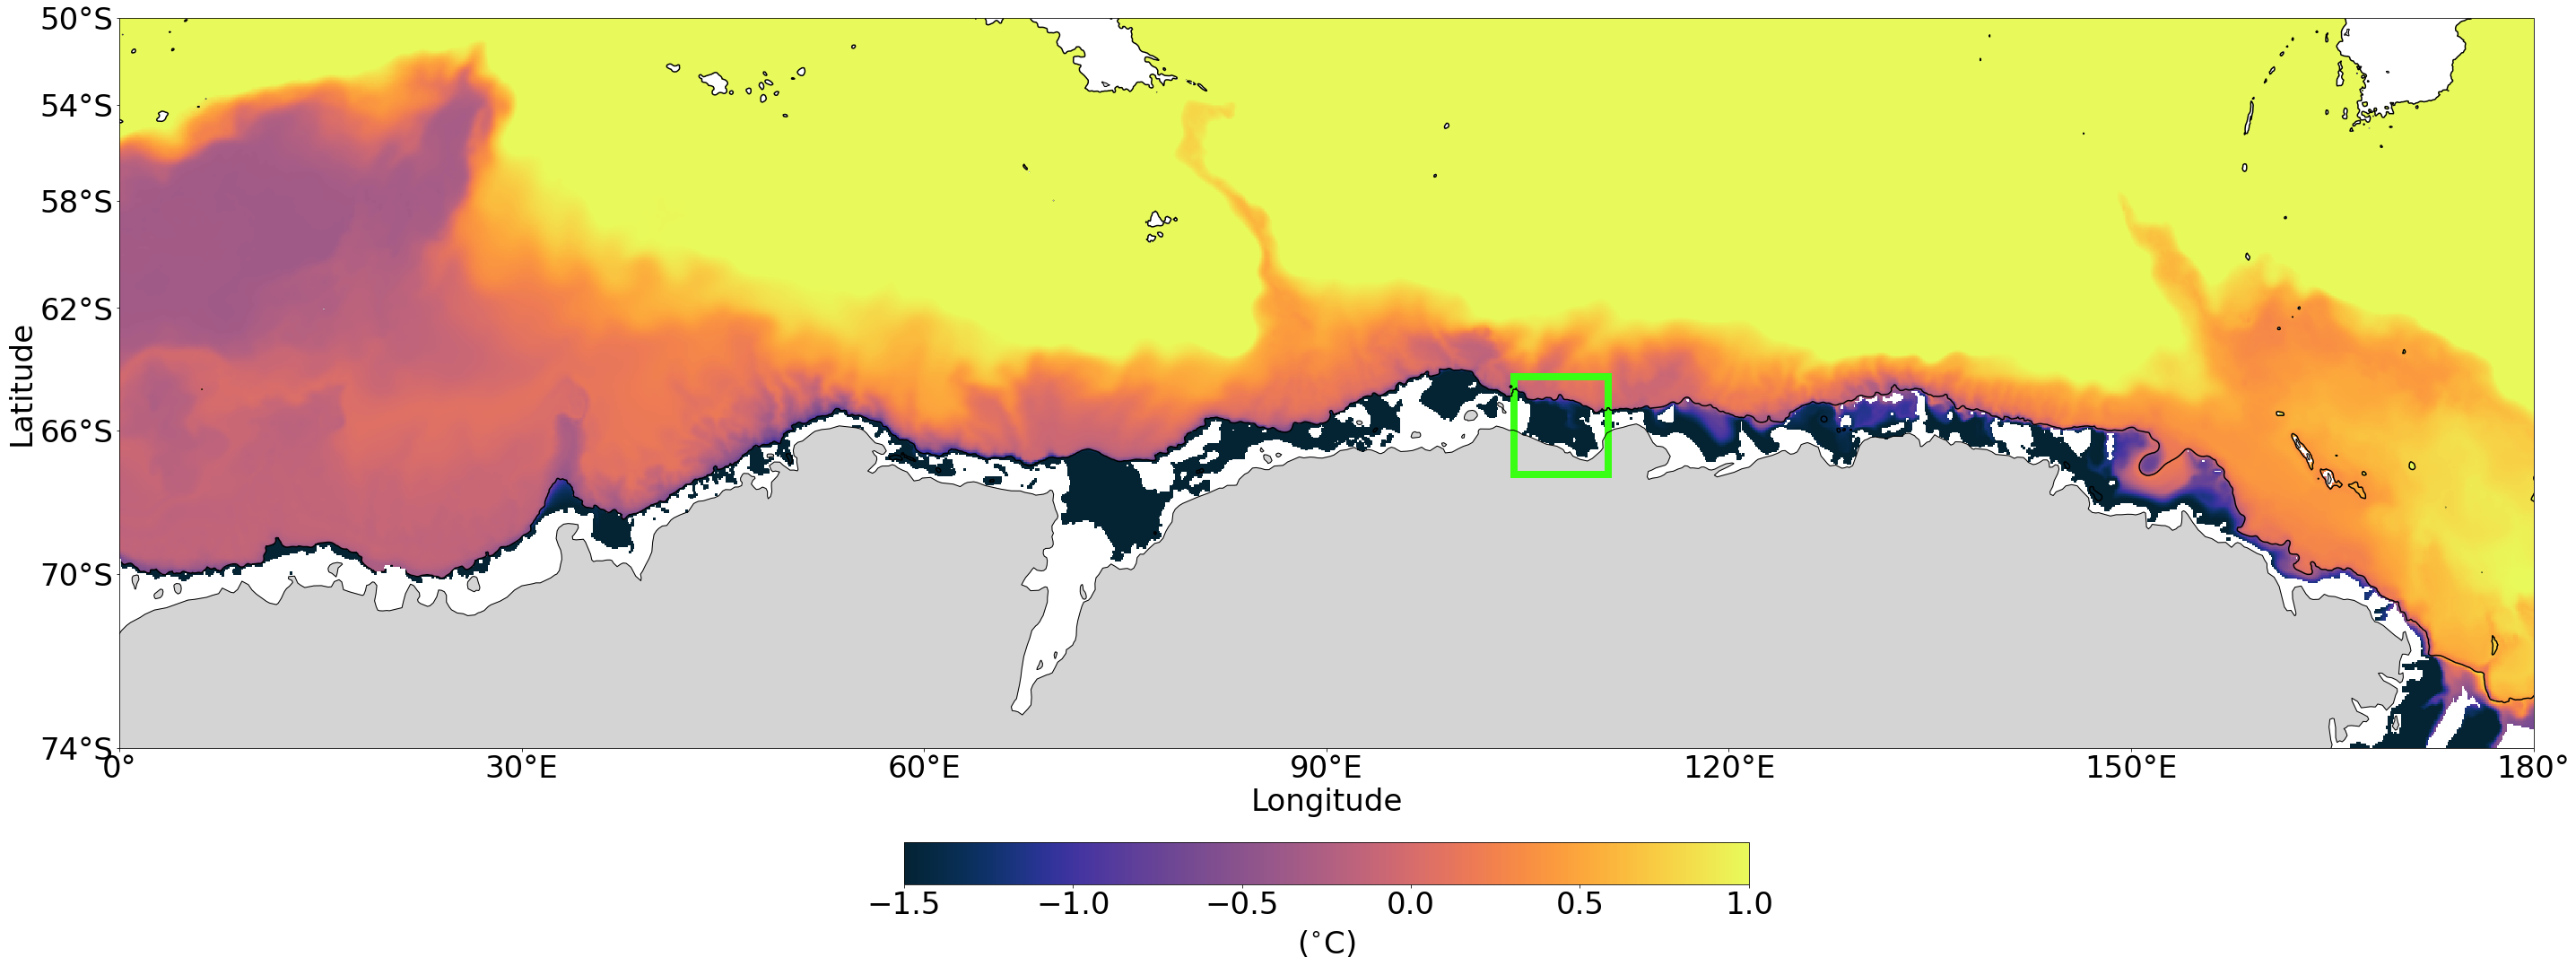

In [55]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
#cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
#cbar.ax.tick_params(labelsize=20)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add colorbar below the plot horizontally
cbar = fig.colorbar(pc, ax=ax, shrink=0.35, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize=fontsize, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_horizontal_cbar_T400.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

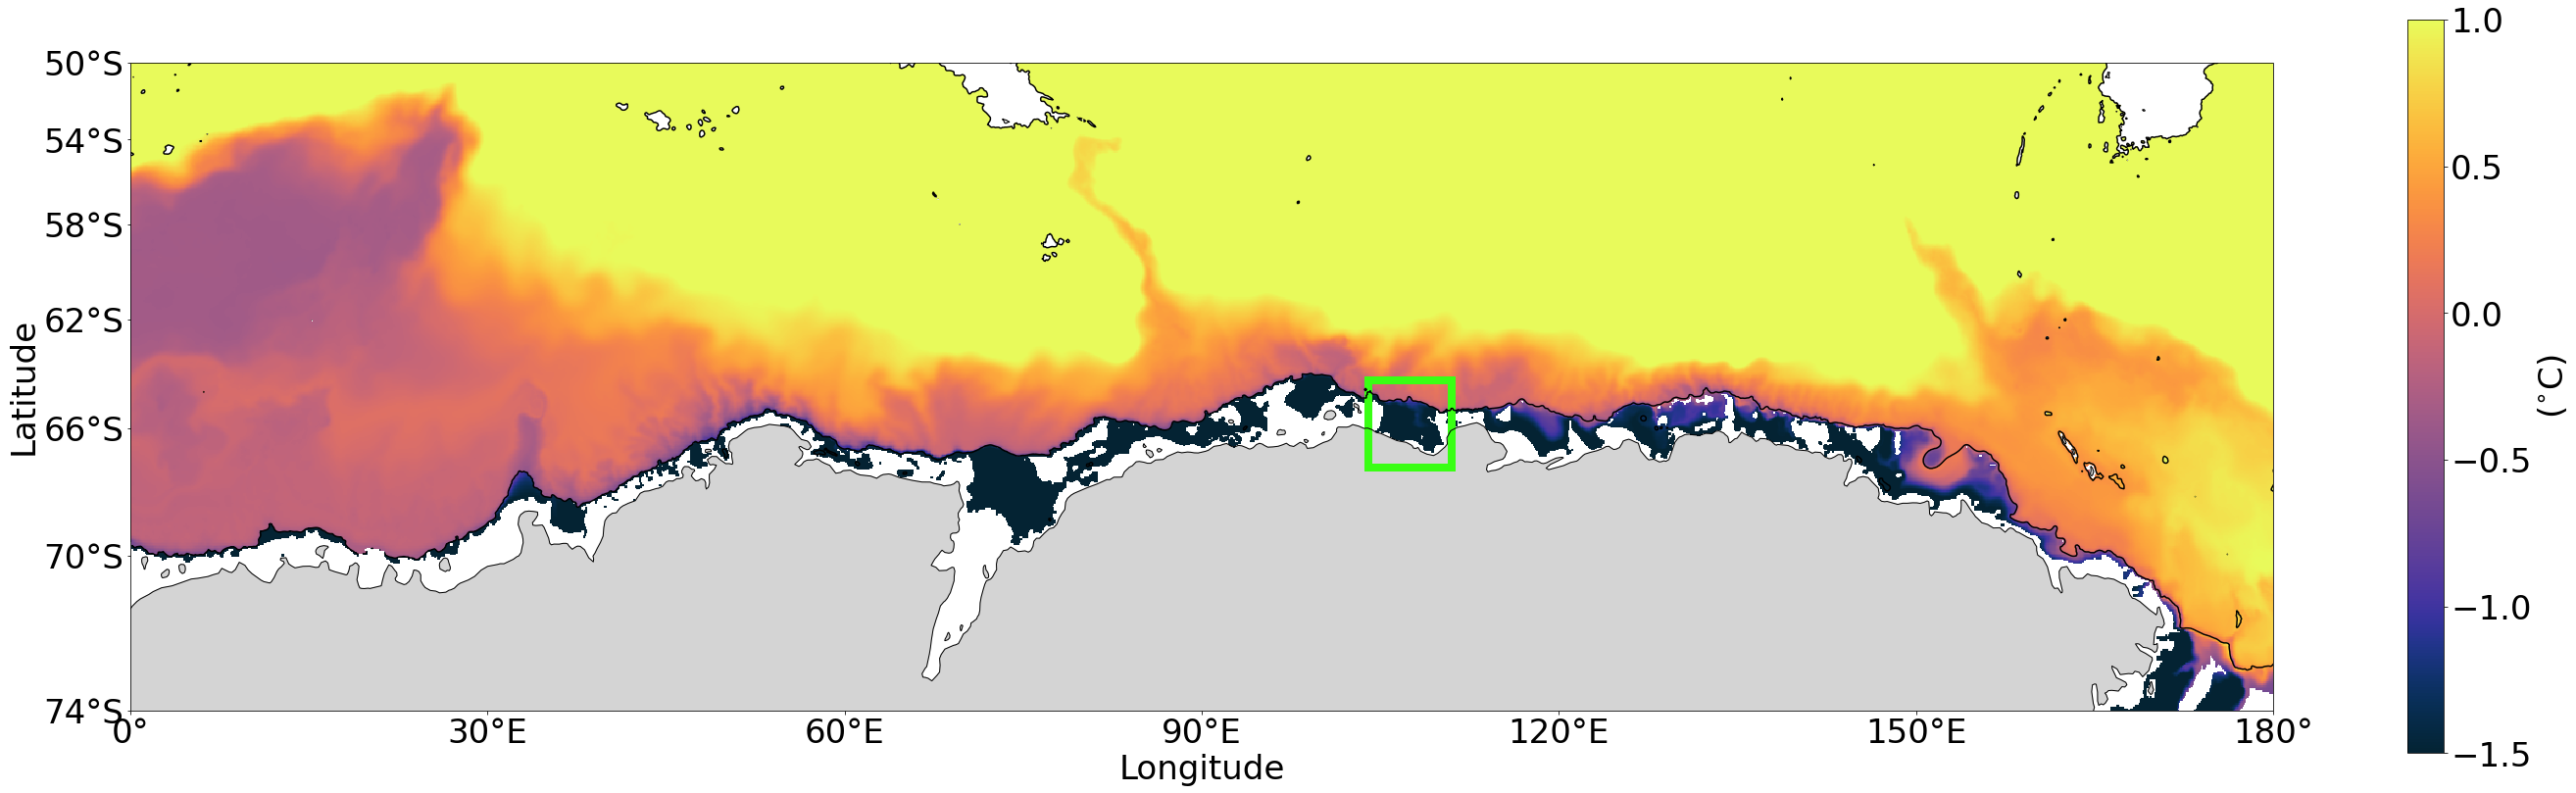

In [56]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_vertical_cbar_T400.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### PLOT MAP v2: IAF bottom temp in the continental shelf and at 1000m  I chose the year of 2012, because it is when we have more seal data to compare the model to. 

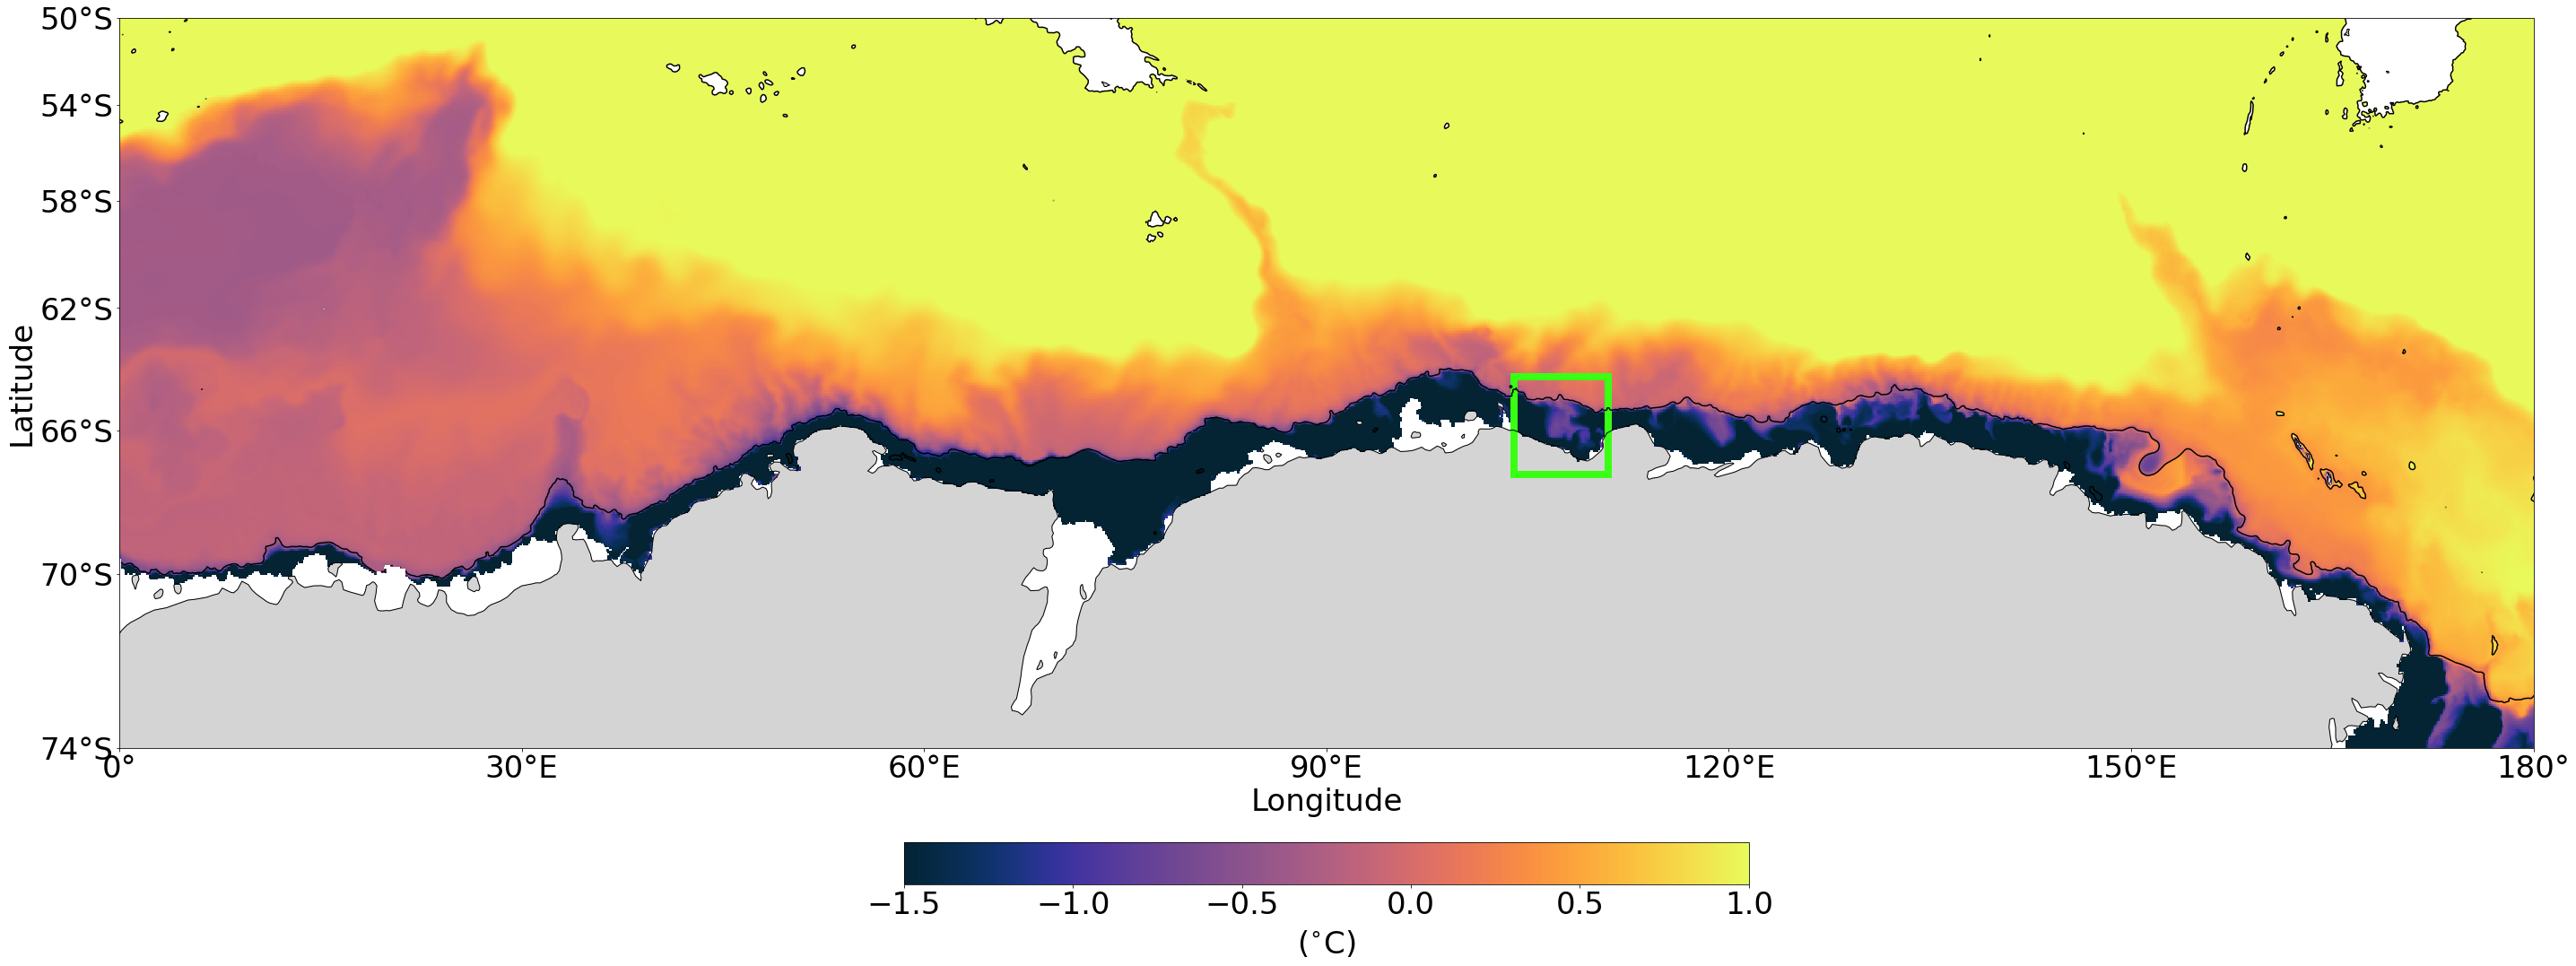

In [57]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(bottom_temp_cycle3_off.xt_ocean,bottom_temp_cycle3_off.yt_ocean,
                        bottom_temp_cycle3_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
#cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
#cbar.ax.tick_params(labelsize=20)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add colorbar below the plot horizontally
cbar = fig.colorbar(pc, ax=ax, shrink=0.35, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize=fontsize, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_horizontal_cbar_bt.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

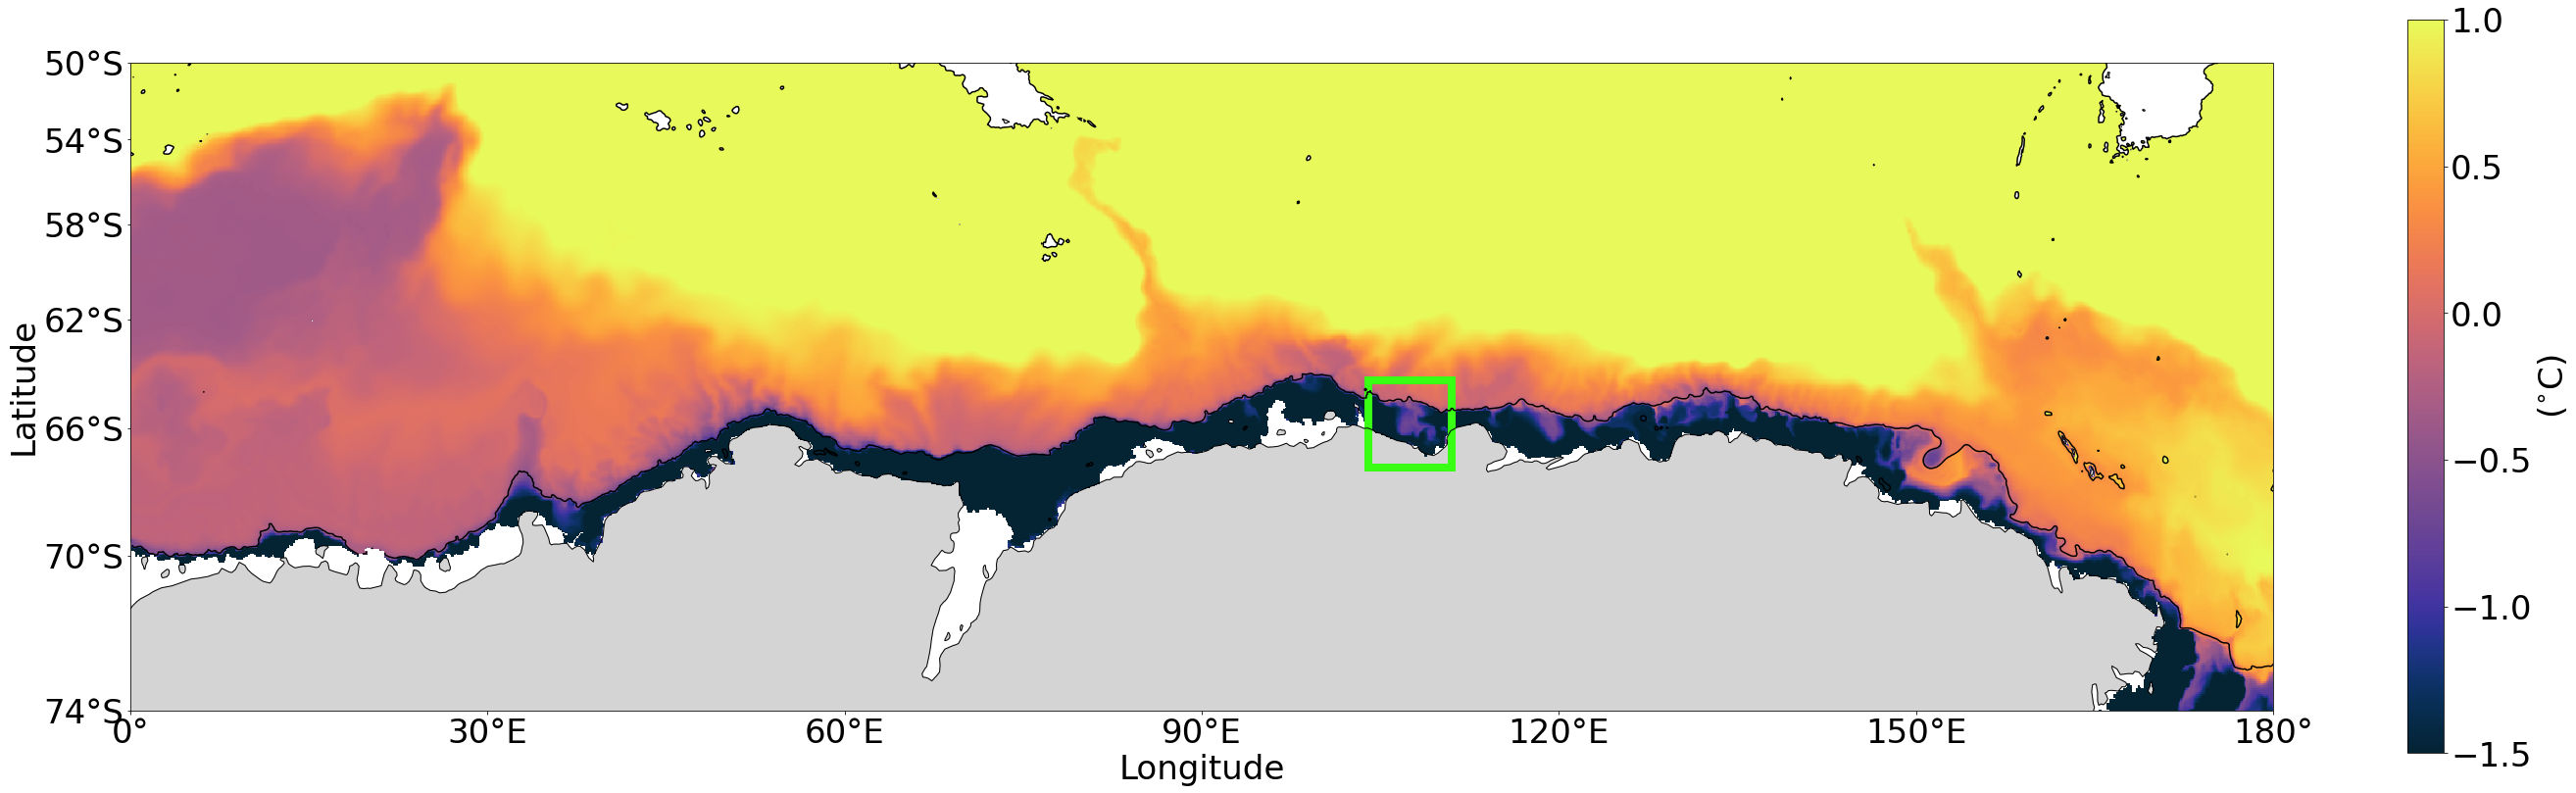

In [58]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(bottom_temp_cycle3_off.xt_ocean,bottom_temp_cycle3_off.yt_ocean,
                        bottom_temp_cycle3_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_vertical_cbar_bt.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### PLOT MAP v3: Observational temperature in the continental shelf and at 1000m offshore.